Predictions with XGboost and Linear Regression

cr: https://www.kaggle.com/dansbecker/xgboost

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

#1. Exploratory Data Analysis

In [15]:
# Read the data into a data frame
data = pd.read_csv('kc_house_data.csv')

In [16]:
# Check the number of data points in the data set
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types
print(data.dtypes.unique())

21613
21
[dtype('int64') dtype('O') dtype('float64')]


Since there are Python objects in the data set, we may have some categorical features. Let's check them.

In [17]:
data.select_dtypes(include=['O']).columns.tolist()

['date']

We only have the date column which is a timestamp that we will ignore.

In [18]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


The data set is pretty much structured and doesn't have any NaN values. So we can jump into finding correlations between the features and the target variable.

# 2. Correlations between features and target

In [19]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [20]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [21]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


We can see that the top 5 features are the most correlated features with the target "price"
Let's plot the best 2 regressors jointly

In [22]:
y = data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

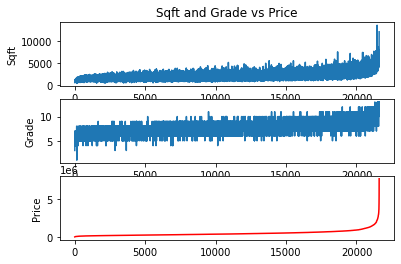

In [23]:
%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show()

# 3. Predicting House Sales Prices

In [25]:
import sklearn
from sklearn import linear_model
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

In [26]:
X = new_data.values
y = data.price.values

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [36]:
regr.fit(X_test,y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 191346.74


In [38]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [39]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

[06:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [40]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.7960403884753028


Our accuracy is changing between 79%. I think it is close to an optimal solution.
 